In [ ]:
# modificado el dataset de producciones poniendo la misma fecha de inicio de produccion a todos los pozos

In [2]:
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                  
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
import sys                                       
import math                                       
import json
#import simplejson
import os                                        
import boto3 
import csv
import io
import re
import s3fs
import math

from random import shuffle
import random
import datetime
from dateutil.relativedelta import relativedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

In [3]:
# para la reproducibilidad del algoritmo
np.random.seed(4216)
random.seed(4216)

In [4]:
sagemaker_session = sagemaker.Session()

In [5]:
# tengo que chequear en que region de la nube estoy trabajando, a que contenedor de objetos de S3 voy a entrar y con que rol estoy trabajando
s3_region = boto3.Session().region_name # veo en que region estoy trabajando
s3_bucket = sagemaker_session.default_bucket()
s3_role = get_execution_role()
print('AWS Region: {}'.format(s3_region))
print('RoleArn: {}'.format(s3_role))

AWS Region: us-east-1
RoleArn: arn:aws:iam::251527064116:role/service-role/AmazonSageMaker-ExecutionRole-20230117T212022


In [6]:
s3_prefix = "sagemaker/forecast_gas_deepar_shift_onedate_tuning" #subcarpeta donde va a quedar todo
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [7]:
# creo la imagen que se va a usar en DeepAR
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", s3_region)

In [8]:
# busco uno de los csv guardados en S3
data_key = 'pruebaDeepAR.csv'
data_location = 's3://{}/{}'.format(s3_bucket, data_key)
df_filtro = pd.read_csv(data_location)
df_filtro.head()

,Unnamed: 0,idpozo,sigla,formacion_productiva,cuenca,yacimiento,longitud_rama_horizontal_m,arena_bombeada_total_tn,prod_gas_cum_Mm3,preds
0,0,146274,tau.nq.ap.e-1002(h),vaca_muerta,neuquina,aguada_pichana_este_vaca_muerta,500.0,1132.000000,23.761476,3
1,1,155721,tau.nq.apfe-112h,vaca_muerta,neuquina,aguada_pichana_este_vaca_muerta,1000.0,1813.181818,30.231886,3
2,2,156714,tau.nq.apig-112(h),vaca_muerta,neuquina,aguada_pichana_este_vaca_muerta,1000.0,1892.272727,30.197952,3
3,3,153806,tau.nq.apge-211(h),vaca_muerta,neuquina,aguada_pichana_este_vaca_muerta,1000.0,1306.818182,26.349922,3
4,4,153705,tau.nq.apge-111(h),vaca_muerta,neuquina,aguada_pichana_este_vaca_muerta,1000.0,1400.000000,45.790747,3


In [9]:
# busco el otro csv guardado en S3
data_key = 'prod_pruebaDeepAR.csv'
data_location = 's3://{}/{}'.format(s3_bucket, data_key)
df_prod_ts = pd.read_csv(data_location)
df_prod_ts.head()

,Unnamed: 0,idpozo,sigla,cuenca,areayacimiento,fecha_data,prod_gas,tef,sub_tipo_recurso,tipopozo,prod_meses,prod_gas_cum_Mm3,prod_gas_km3d
0,198377,160169,pae.nq.acas-101(h),neuquina,aguada_de_castro,2019-01-31,1742.040,15.43750,shale,gasifero,1,1.742040,112.844696
1,190834,160169,pae.nq.acas-101(h),neuquina,aguada_de_castro,2019-02-28,8279.013,27.00347,shale,gasifero,2,10.021053,306.590709
2,191357,160169,pae.nq.acas-101(h),neuquina,aguada_de_castro,2019-03-31,10462.460,30.61528,shale,gasifero,3,20.483513,341.739811
3,192219,160169,pae.nq.acas-101(h),neuquina,aguada_de_castro,2019-04-30,10703.320,26.99653,shale,gasifero,4,31.186833,396.470213
4,192780,160169,pae.nq.acas-101(h),neuquina,aguada_de_castro,2019-05-31,12393.380,29.78611,shale,gasifero,5,43.580213,416.079172


In [10]:
# realizo los filtros para quedarme solo con las columnas de interes
# filtro el dataset  para obtener el grupo de pozos del cluster 0
df_filtro_mod = df_filtro[df_filtro['preds']==0]
well_to_forecast = df_filtro_mod['idpozo'].unique()

# me quedo solo con los pozos del cluster 0 en producciones
df_prod_ts_mod = df_prod_ts[df_prod_ts['idpozo'].isin(well_to_forecast)]

# elimino las columnas solo para quedarme con idpozo, fecha, prod_gas_km3d
column_filter = ['sigla','fecha_data','prod_gas_km3d']
df_prod_ts_mod = df_prod_ts_mod[column_filter]

# convierto el dataset en el formato necesario para deepaR
df_dic = df_prod_ts_mod.groupby('sigla').apply(lambda x: dict(zip(x.fecha_data, x.prod_gas_km3d))).to_dict()
df_new_ts = pd.DataFrame.from_dict(df_dic, orient = 'columns')
#df_new_ts.reset_index(inplace = True)
#df_new_ts = df_new_ts.rename(columns={'index':'ts'})
df_new_ts.index = pd.to_datetime(df_new_ts.index)
df_new_ts.index.inferred_type == "datetime64"
#df_new_ts.info()


True

In [11]:
# creo un nuevo dataset donde pongo el mismo inicio de produccion para todos los pozos. El primer datos es el 04-2018
df_new_ts_2 = df_new_ts.copy()
start_dataset = df_new_ts_2.index.min()
for col in df_new_ts_2:
    first_valid_index = df_new_ts_2.loc[:,col].first_valid_index()
    move = int((first_valid_index.year - start_dataset.year)*12 + first_valid_index.month - start_dataset.month)*(-1)
    #print(move)
    df_new_ts_2[col] = df_new_ts_2[col].shift(periods = move)

df_new_ts_2.head()
#df_new_ts_2.shape

,pae.nq.apo-102(h),pae.nq.apo-103(h),pae.nq.apo-104(h),pae.nq.apo-202(h),pae.nq.apo-203(h),pae.nq.apo-204(h),pae.nq.apo-205(h),pae.nq.apo.x-101(h),pae.nq.apo.x-201(h),tau.nq.ap-1008(h),...,tpt.nq.fp-1204(h),tpt.nq.fp-1322(h),ypf.nq.rdmn-12(h),ypf.nq.rdmn-16(h),ypf.nq.rdmn-17(h),ypf.nq.rdmn-18(h),ypf.nq.rdmn-25(h),ypf.nq.rdmn-26(h),ypf.nq.rdmn-29(h),ypf.nq.rdmn-40(h)(i)
2018-04-30,68.508900,163.183248,165.513831,315.652673,188.222166,223.197986,208.113833,177.502957,57.795919,9.961939,...,43.465618,82.813380,49.454340,143.063745,133.510448,133.927961,262.498018,365.985682,269.895258,350.787626
2018-05-31,309.666335,391.397193,315.068140,507.135484,382.313539,450.535149,429.997196,362.753846,330.264581,100.142550,...,324.009233,276.100219,181.750081,373.614587,418.230694,445.650809,529.409125,544.143717,437.009065,509.059973
2018-06-30,367.040340,362.744773,288.840925,550.328988,430.401656,453.756687,531.013830,403.657432,373.282536,264.950630,...,458.143576,250.459329,341.464960,398.278528,446.349249,478.104787,593.479818,466.584955,336.483472,503.248465
2018-07-31,377.692209,371.130886,288.875821,529.630000,456.938243,437.152469,639.464102,406.301667,405.815621,292.910136,...,397.364516,261.403320,398.626005,474.774453,412.424196,455.643249,592.823150,436.369194,333.733266,476.099071
2018-08-31,404.748927,358.170126,283.842962,514.036586,399.311422,377.686880,598.299367,399.521885,379.052333,281.286917,...,421.716071,243.854473,360.819474,495.785460,358.508393,419.930323,534.741540,397.328826,299.891089,390.760244


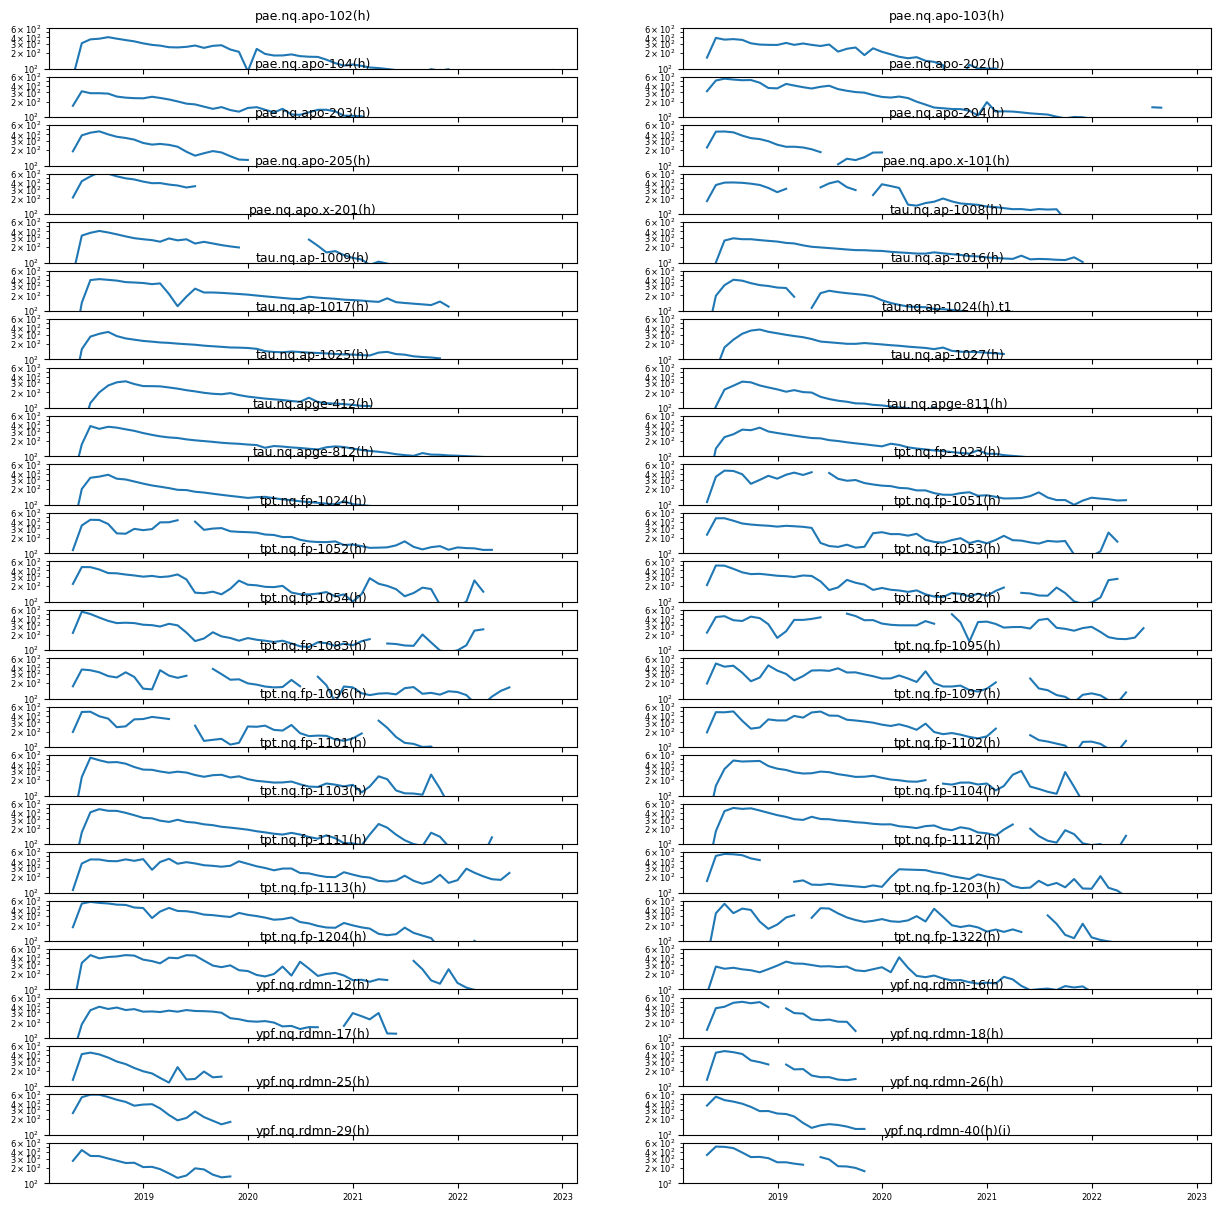

In [12]:
# grafico todas las time series
row= math.ceil(int(df_new_ts.shape[1]/2))
fig, axs = plt.subplots(row,2, figsize = (15,15), sharex = True)
axx = axs.ravel()
for col, ax in zip(df_new_ts_2.columns[0:], axs.flatten()):
    ax.plot(df_new_ts_2.index, df_new_ts_2[col])
    #ax.set(xlabel = 'time', ylabel = ' prod')
    ax.set_title(df_new_ts[col].name, size=9)
    ax.tick_params(axis='y', which='both', labelsize = 6)
    ax.tick_params(axis='x', which='both', labelsize = 6)
    ax.set_yscale('log')
    ax.set_ylim([100,600])
plt.show()


In [13]:
# https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html
# The Amazon SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) 
# time series using recurrent neural networks (RNN). Classical forecasting methods, such as autoregressive integrated moving average (ARIMA) or exponential smoothing (ETS), 
# fit a single model to each individual time series. They then use that model to extrapolate the time series into the future.
# You can also use the trained model to generate forecasts for new time series that are similar to the ones it has been trained on
# Null values: https://aws.amazon.com/es/blogs/machine-learning/amazon-sagemaker-deepar-now-supports-missing-values-categorical-and-time-series-features-and-generalized-frequencies/
# https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.html
# https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb
# https://calvinfeng.gitbook.io/machine-learning-notebook/sagemaker/time_series_forecast

In [68]:
timeseries = []
for i in df_new_ts_2:
    a = df_new_ts_2.loc[:,i].first_valid_index()
    b= df_new_ts_2.index[-1]
    timeseries.append(np.trim_zeros(df_new_ts_2.loc[a:b,i], trim='f'))  
#print(timeseries[1])

2018-04-30    163.183248
2018-05-31    391.397193
2018-06-30    362.744773
2018-07-31    371.130886
2018-08-31    358.170126
2018-09-30    308.165571
2018-10-31    291.068671
2018-11-30    287.589560
2018-12-31    286.399257
2019-01-31    313.203400
2019-02-28    287.478347
2019-03-31    305.505072
2019-04-30    287.276935
2019-05-31    273.408518
2019-06-30    291.904027
2019-07-31    212.929694
2019-08-31    241.794881
2019-09-30    255.799374
2019-10-31    182.313129
2019-11-30    246.700728
2019-12-31    211.569051
2020-01-31    189.004956
2020-02-29    169.419595
2020-03-31    158.746246
2020-04-30    166.448297
2020-05-31    141.978764
2020-06-30    135.002440
2020-07-31    117.015918
2020-08-31     17.891361
2020-09-30     61.666964
2020-10-31    119.181820
2020-11-30    100.599579
2020-12-31    100.569047
2021-01-31    100.636698
2021-02-28     79.567278
2021-03-31           NaN
2021-04-30           NaN
2021-05-31           NaN
2021-06-30           NaN
2021-07-31           NaN


In [65]:
# borro los None desde el ultimo dato valido
timeseries_2 = []
time_max = df_new_ts_2.index.max()
for ts in timeseries:
    time_last_prod = ts.last_valid_index()
    ts_2 = ts.loc[:time_last_prod]
    timeseries_2.append(ts_2)
#timeseries_2

In [16]:
# los valores nulos que se encuentran en el medio del dataset los cambio por 0 (pozo cerrado) ya que no lo soporta json
for ts in timeseries_2:
    ts.fillna(value=0, inplace=True)

In [17]:
freq = 'M'
prediction_length = 4 #num de meses para adelante que tiene que proyectar
context_length = 4 #num de meses que mira para tras para proyectar
num_test_window = 1 #cuanto para adelante quiero segun el prediction_length. No lo voy a usar ahora

In [18]:
# código para armar el cjto de training y testing. Se arma el cjto dando inicio cada serie en el tiempo en que comienza la produccion de cada pozo
# se generan los bucles para crear una lista con todas las fechas, dentro de cada fecha hay un diccionario cuya key es la fecha de inicio y la data es la produccion desde esa fecha hasta el final de cada cjto 

#end_training =  pd.Timestamp(str(df_new_ts.index.max()-relativedelta(months=prediction_length)), freq = freq)

training_data = [
    {
        "start": str(ts.index[0]),
        "target": ts[ts.index[0]: ts.index[-1] - relativedelta(months=1)].tolist()
        ,  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries_2
]
print(len(training_data))

#armo el cjto de testeo que tiene que ser toda lo que esta en training mas los meses que se dejaron afuera

test_data = [
    {
        "start": str(ts.index[0]),
        "target": ts[ts.index[0]: ts.index[-1]  + relativedelta(months=k * prediction_length)].tolist()
    }
    for k in range(1, num_test_window + 1) #k no lo voy a usar por ahora estaba el demo-electricity
    for ts in timeseries_2
]
print(len(test_data))

48
48


In [71]:
print(training_data[0])

{'start': '2018-04-30 00:00:00', 'target': [68.5089, 309.6663347162083, 367.0403404255319, 377.6922092018801, 404.748926948112, 378.4076666666666, 355.5009677419355, 335.70727420934685, 307.2707511127703, 287.116929358922, 277.8996563701903, 258.9406451612903, 256.5395963589104, 263.15665040650407, 279.1856667519836, 251.5623424974126, 275.1730322580645, 282.8231271471091, 233.6605735316769, 211.04545454545453, 89.15496151808752, 240.5907610619469, 192.291169451074, 179.2925704849535, 179.628167539267, 188.29243521279037, 174.31778714746935, 169.82186483446526, 168.38513457556937, 148.90246429751153, 127.29153368352522, 114.75613823064955, 120.44608848968704, 113.03938955965236, 105.39637001775311, 102.64758254825968, 98.43934242903168, 93.67081170993283, 92.3412416421173, 89.73866417408084, 83.65033044507958, 97.84846642348772, 90.929581029967, 97.78925714285714, 67.99419778201708, 62.54717158915842, 68.41660428215849, 69.51665040650407, 70.74292655891405, 70.4636251747656, 71.5872226

In [70]:
# guardo todo en archivo json que es lo que ingresa a DeepAR tomando los datos desde S3
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [20]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 4.95 ms, sys: 38 µs, total: 4.99 ms
Wall time: 41.2 ms


In [21]:
# copio los json a S3
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-251527064116/sagemaker/forecast_gas_deepar_shift_onedate_tuning/data/train/train.json
Uploading file to s3://sagemaker-us-east-1-251527064116/sagemaker/forecast_gas_deepar_shift_onedate_tuning/data/test/test.json


In [22]:
# train Model
estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    sagemaker_session=sagemaker_session,
    role=s3_role,
    train_instance_count=1,
    train_instance_type="ml.m4.xlarge",
    base_job_name="deepar-forecast-gas-model",
    output_path=s3_output_path,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [23]:
# voy hacer un tuning de los hiperparámetros para encontrar el mejor modelo
#https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/deepar_chicago_traffic_violations/deepar_chicago_traffic_violations.html
static_hyperparameters = {
    "time_freq": freq,
    #"epochs": "100",
    "early_stopping_patience": "40",
    "likelihood":"gaussian",
    #"mini_batch_size": "35",
    #"learning_rate": "5E-3",
    #"num_cells": "30",
    "num_layers": "2",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [24]:
estimator.set_hyperparameters(**static_hyperparameters)
data_channels = {"train": f"{s3_data_path}/train/", "test":f"{s3_data_path}/test/"}

In [25]:
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter

In [26]:
tuned_hyperparameter_ranges={
    'num_cells': IntegerParameter(30,100), # typical value range 30 to 100
    'num_layers': IntegerParameter(1,4), # num of hidden layers. Typical from 1 to 4
    'dropout_rate': ContinuousParameter(0.0,0.2), # rondom subset of hidden neurons are not updated. Typical values are less than 0.2
    #'embedding_dimension': IntegerParameter(10,100),
    'learning_rate': ContinuousParameter(1e-5,0.1),
    'epochs': IntegerParameter(50,200),
    'mini_batch_size': IntegerParameter(5,45),
}

In [27]:
%%time
tuner = HyperparameterTuner(estimator,
                            objective_metric_name='test:RMSE',
                            objective_type='Minimize',
                            hyperparameter_ranges=tuned_hyperparameter_ranges,
                            max_jobs=50,
                            max_parallel_jobs=5)

CPU times: user 50 µs, sys: 2 µs, total: 52 µs
Wall time: 55.6 µs


In [28]:
tuner.fit(inputs=data_channels, job_name='tune-forecast-v3', include_cls_metadata=False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................!


In [29]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

best_tuning_job_name = tuner.best_training_job()
endpoint = tuner.deploy(
    initial_instance_count=1,
    endpoint_name=best_tuning_job_name,
    instance_type='ml.m4.xlarge',
    serializer=IdentitySerializer(content_type='application/json'),
    deserializer=JSONDeserializer(),
    wait=True,
)                                


2023-01-27 18:37:59 Starting - Found matching resource for reuse
2023-01-27 18:37:59 Downloading - Downloading input data
2023-01-27 18:37:59 Training - Training image download completed. Training in progress.
2023-01-27 18:37:59 Uploading - Uploading generated training model
2023-01-27 18:37:59 Completed - Resource reused by training job: tune-forecast-v3-045-875ee406
----------!

In [30]:
# defino al funcion que luego voy a usar en la class DeepARPredictor
def series_to_obj(ts, cat=None):
    count = 0
    for i in ts:
        if i == 'NaN':
            count += 1
    if count != len(ts):
        obj = {"start": str(ts.index[0]), "target": list(ts)}
    else:
        obj = {"start": str(ts.index[0]), "target": []}
    if cat is not None:
        obj["cat"] = cat
    return obj


def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [31]:
# creo la clase para hacer las predicciones de mas de una time serie
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )
    def set_prediction_parameters(self,freq,prediction_length):
        self.freq=freq
        self.prediction_length=prediction_length
    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        prediction_times = [x.index[-1] + relativedelta(months=1) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

In [32]:
time_series_training = []
for ts in timeseries_2:
    time_series_training.append(ts[:-prediction_length])

In [33]:
predictor = DeepARPredictor(endpoint_name=endpoint.endpoint_name, sagemaker_session=sagemaker_session)

In [78]:
predictor.set_prediction_parameters(freq,prediction_length)
list_of_df = predictor.predict(ts=time_series_training[34:])
actual_data=timeseries_2[34:]
#print(list_of_df)

In [83]:
#grafico las predicciones
def plot_predictions (list_of_df, actual_data):
    row_plot=math.ceil(int(len(actual_data)/2))
    fig,axs = plt.subplots(row_plot, 2, figsize= (15,15), sharex = True)
    axx = axs.ravel()
    for k, ax in zip(range(len(list_of_df)), axs.flatten()):
        #plt.figure(figsize=(12, 6))
        #actual_data[k][-prediction_length - context_length :].plot(ax=ax,label="target")
        ax.plot(actual_data[k][-prediction_length - 100*context_length :], label = 'target')
        p10 = list_of_df[k]["0.1"]
        p90 = list_of_df[k]["0.9"]
        ax.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
        ax.plot(list_of_df[k]["0.5"],label="prediction median")
        #ax.set_title(actual_data[k].name, size=9)
        #ax.set_ylabel('gas(km3/d)', fontsize = 5) # Y label
        #ax.set_xlabel('Active Cdc2-cyclin B', fontsize = 20) # X label
        #ax.set_yscale('log')
        ax.tick_params(axis='y', which='both', labelsize = 6)
        ax.tick_params(axis='x', which='both', labelsize = 6)
        #ax.set_ylim([10,600])
        #ax.legend(prop={'size':10})
    return plt.show()
#plt.savefig('forecast_onedate.png')

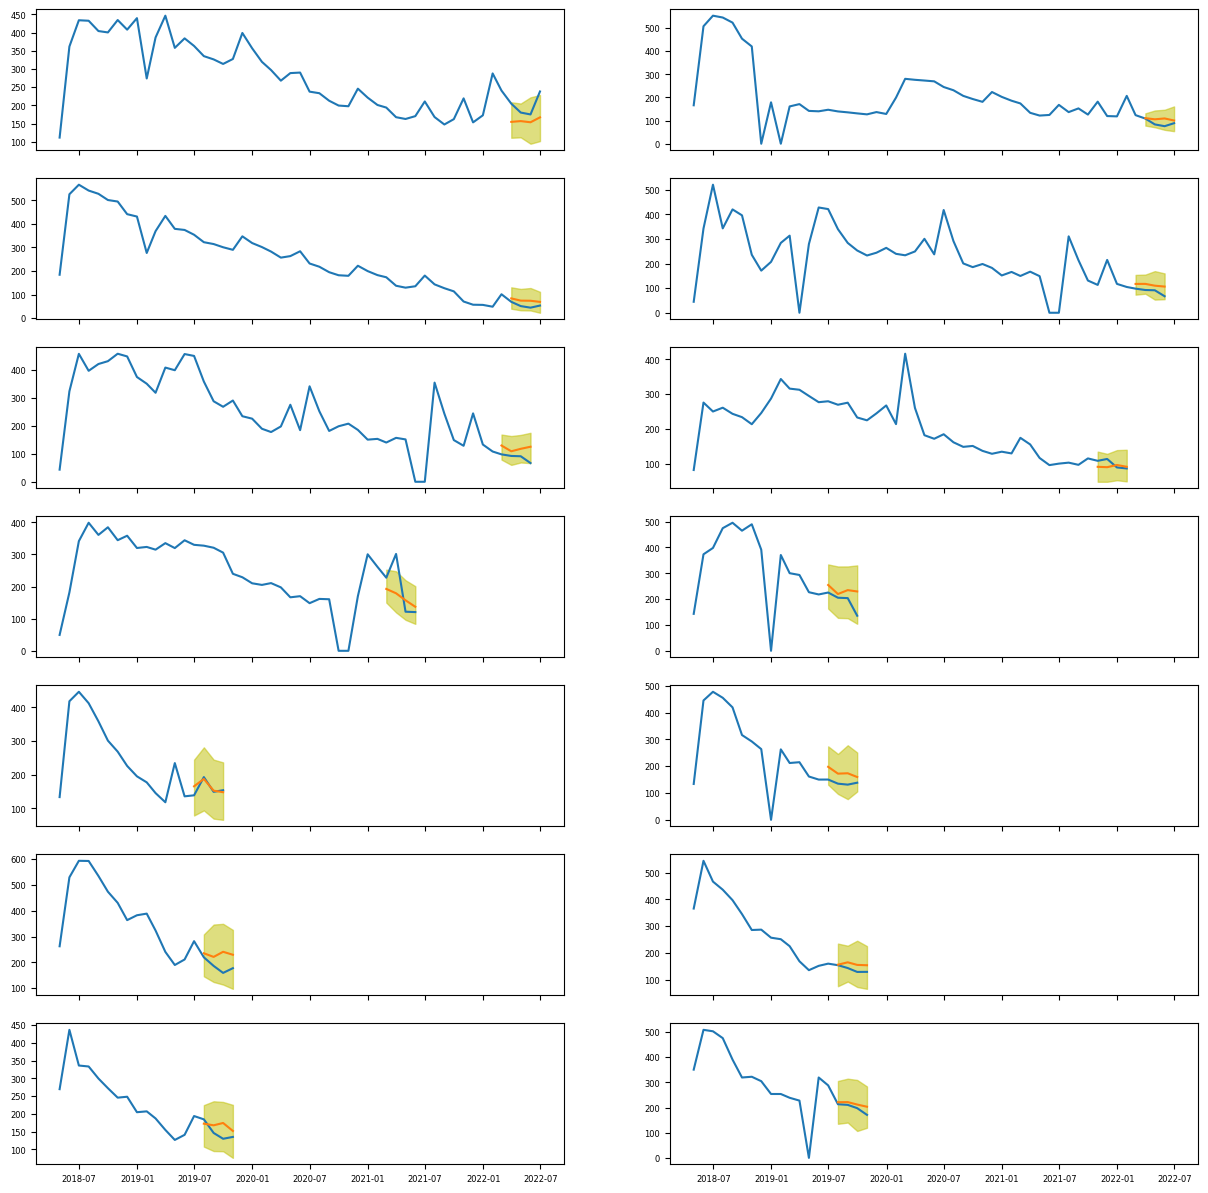

In [84]:
plot_predictions(list_of_df, actual_data)

In [37]:
# creo la clase para hacer las predicciones de una sola ts
class DeepARPredictor2(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )
    def set_prediction_parameters(self,freq,prediction_length):
        self.freq=freq
        self.prediction_length=prediction_length
        
    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        prediction_times = ts.index[-1] + relativedelta(months=1) 
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor2, self).predict(req,initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts, cat if cat else None)]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        prediction_index = pd.date_range(start=prediction_times, freq=self.freq, periods=self.prediction_length)
        #list_of_df = []
        #for k in range(len(prediction_times)):
        df = pd.DataFrame(data=response_data["predictions"][0]["quantiles"], index=prediction_index)
        return df

In [38]:
predictor2 = DeepARPredictor2(endpoint_name=endpoint.endpoint_name, sagemaker_session=sagemaker_session)
predictor2.set_prediction_parameters(freq, prediction_length)

In [39]:
# creo la prediccion para un pozo nuevo
start_date = '2022-12-31' # We want to predict first 4 months in 2023
timestamp = '00:00:00'
index = pd.date_range(pd.Timestamp(start_date) + relativedelta(months=1), periods=prediction_length, freq='M')
columns = ['new_well']
df_new_well = pd.DataFrame(index = index, columns = columns)
print(df_new_well)
df_new_well_bis = df_new_well.fillna(value='NaN')
print(df_new_well_bis)
actual_data_new_well = pd.DataFrame(index = index, columns = columns)
#actual_data_new_well.fillna(0, inplace = True)
print(actual_data_new_well)

           new_well
2023-01-31      NaN
2023-02-28      NaN
2023-03-31      NaN
2023-04-30      NaN
           new_well
2023-01-31      NaN
2023-02-28      NaN
2023-03-31      NaN
2023-04-30      NaN
           new_well
2023-01-31      NaN
2023-02-28      NaN
2023-03-31      NaN
2023-04-30      NaN


In [40]:
ts_new_well = df_new_well_bis['new_well'].squeeze()
print(type(ts_new_well))
print(len(ts_new_well))

<class 'pandas.core.series.Series'>
4


In [41]:
new_well = predictor2.predict(ts=ts_new_well, content_type="application/json")

In [42]:
print(new_well)

                   0.1         0.5         0.9
2023-05-31   24.885025  211.892212  384.060547
2023-06-30  152.558105  301.126373  428.200562
2023-07-31  131.562500  292.244446  464.227386
2023-08-31  133.954590  303.462769  480.072174


In [43]:
def plot_new_wells (prediction, actual_data):
    plt.figure(figsize=(12, 6))
    actual_data[:].plot(label="target")
    p10 =prediction["0.1"]
    p90 = prediction["0.9"]
    plt.fill_between(p10.index, p10, p90, color="y", alpha=0.5, label="80% confidence interval")
    prediction["0.5"].plot(label="prediction median")
    plt.legend()
    return plt.show()

<Figure size 1200x600 with 0 Axes>

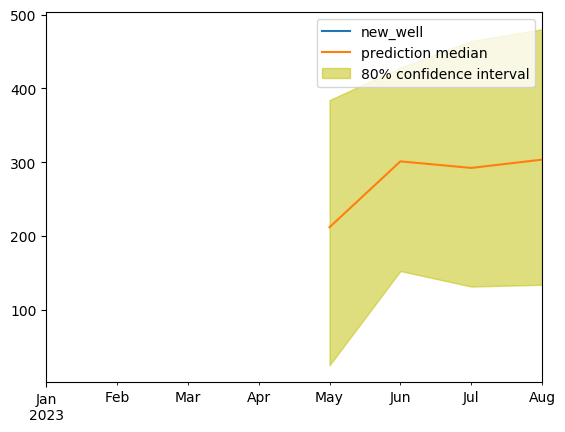

In [44]:
plot_new_wells(new_well, actual_data_new_well)

In [45]:
# creo la prediccion para un pozo con poca historia de produccion AP-1045
start_date = '2022-2-28' # We want to predict first 4 months in 2023
timestamp = '00:00:00'
columns = ['new_well']
production = [288.25,439.04] 
index = pd.date_range(pd.Timestamp(start_date) + relativedelta(months=1), periods=len(production), freq='M')
df_new_well_2 = pd.DataFrame(production, index = index, columns = columns)
print(df_new_well_2)
total_production = [288.25,439.03,448.2,490.7,459.88,383.41,396.79,395.86,376.63,359.37]
index_2 = pd.date_range(pd.Timestamp(start_date) + relativedelta(months=1), periods=len(total_production), freq='M')
actual_data_new_well_2 = pd.DataFrame(total_production, index = index_2, columns = columns)
#actual_data_new_well.fillna(0, inplace = True)
print(actual_data_new_well_2)

            new_well
2022-03-31    288.25
2022-04-30    439.04
            new_well
2022-03-31    288.25
2022-04-30    439.03
2022-05-31    448.20
2022-06-30    490.70
2022-07-31    459.88
2022-08-31    383.41
2022-09-30    396.79
2022-10-31    395.86
2022-11-30    376.63
2022-12-31    359.37


In [46]:
ts_new_well_2 = df_new_well_2['new_well'].squeeze()
print(type(ts_new_well))
print(len(ts_new_well))

<class 'pandas.core.series.Series'>
4


In [47]:
new_well_2 = predictor2.predict(ts=ts_new_well_2, content_type="application/json")

In [48]:
print(new_well_2)

                   0.1         0.5         0.9
2022-05-31  279.324554  485.785431  750.287842
2022-06-30  305.693481  479.393250  687.931213
2022-07-31  294.397766  452.653687  608.473999
2022-08-31  222.326004  357.840851  492.192566


<Figure size 1200x600 with 0 Axes>

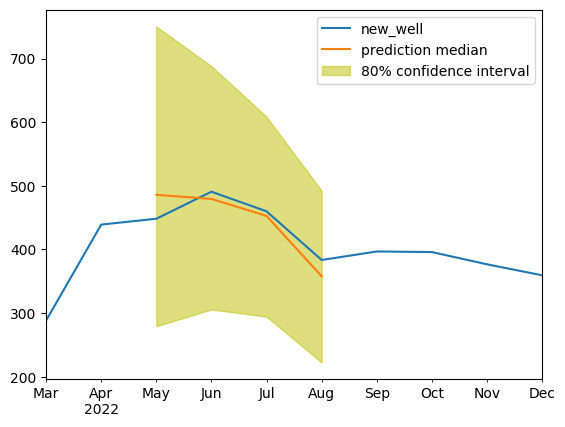

In [49]:
plot_new_wells(new_well_2,actual_data_new_well_2)

In [50]:
#predictor.delete_endpoint()

In [51]:
# pruebo predecir todos los pozos con menos de 18 meses en produccion
# busco uno de los csv guardados en S3
data_key = 'new_wells_DeepAR.csv'
data_location = 's3://{}/{}'.format(s3_bucket, data_key)
df_filtro_new_wells = pd.read_csv(data_location)
df_filtro_new_wells.head()

,Unnamed: 0,idpozo,sigla,formacion_productiva,cuenca,yacimiento,longitud_rama_horizontal_m,cantidad_fracturas,agua_inyectada_m3,arena_bombeada_total_tn,preds
0,1500,160206,tpt.nq.fp-1323(h),vaca_muerta,neuquina,fortin_de_piedra,2516.0,19,30096.500000,4350.740,0
1,2793,162600,pae.nq.apo-108(h),vaca_muerta,neuquina,aguada_pichana_oeste,1800.0,26,41297.430000,5445.950,2
2,2794,162609,tau.nq.ap-1036(h),vaca_muerta,neuquina,aguada_pichana_este_vaca_muerta,2647.4,36,73441.000000,9906.000,0
3,2795,162610,tau.nq.ap-1038(h),vaca_muerta,neuquina,aguada_pichana_este_vaca_muerta,2678.4,36,73735.000000,10031.000,0
4,2978,163170,ypf.nq.rdmn-83(h),vaca_muerta,neuquina,rincon_del_mangrullo,2507.0,37,72587.501874,8567.451,0


In [52]:
# realizo los filtros para quedarme solo con las columnas de interes
# filtro el dataset  para obtener el grupo de pozos del cluster 0
df_filtro_new_wells_mod = df_filtro_new_wells[df_filtro_new_wells['preds']==0]
new_wells_to_forecast = df_filtro_new_wells_mod['idpozo'].unique()

# me quedo solo con los pozos del cluster 0 en producciones
df_prod_new_wells = df_prod_ts[df_prod_ts['idpozo'].isin(new_wells_to_forecast)]

# elimino las columnas solo para quedarme con idpozo, fecha, prod_gas_km3d
#column_filter = ['sigla','fecha_data','prod_gas_km3d']
df_prod_new_wells = df_prod_new_wells[column_filter]

# convierto el dataset en el formato necesario para deepaR
df_dic_new_wells = df_prod_new_wells.groupby('sigla').apply(lambda x: dict(zip(x.fecha_data, x.prod_gas_km3d))).to_dict()
df_new_wells = pd.DataFrame.from_dict(df_dic_new_wells, orient = 'columns')
df_new_wells.dropna(axis=0, how='all', inplace=True)
df_new_wells.dropna(axis=1, how='all', inplace=True)
#df_new_ts.reset_index(inplace = True)
#df_new_ts = df_new_ts.rename(columns={'index':'ts'})
df_new_wells.index = pd.to_datetime(df_new_wells.index)
df_new_wells.index.inferred_type == "datetime64"
#df_new_ts.info()
#print(df_dic_new_wells)
#print(df_new_wells)

True

In [53]:
# creo un nuevo dataset donde pongo el mismo inicio de produccion para todos los pozos. 
df_new_wells_2 = df_new_wells.copy()
start_dataset_new_wells = df_new_wells_2.index.min()
for col in df_new_wells_2:
    first_valid_index_new_wells = df_new_wells_2.loc[:,col].first_valid_index()
    move = int((first_valid_index_new_wells.year - start_dataset_new_wells.year)*12 + first_valid_index_new_wells.month - start_dataset_new_wells.month)*(-1)
    #print(move)
    df_new_wells_2[col] = df_new_wells_2[col].shift(periods = move)
df_new_wells_2.head()

,pae.nq.apo-107(h),tau.nq.ap-1028(h),tau.nq.ap-1030(h),tau.nq.ap-1032(h).t1,tau.nq.ap-1033(h),tau.nq.ap-1036(h),tau.nq.ap-1038(h),tau.nq.ap-1040(h),tau.nq.ap-1041(h),tau.nq.ap-1044(h),...,ypf.nq.rdmn-217(h),ypf.nq.rdmn-224(h),ypf.nq.rdmn-226(h),ypf.nq.rdmn-229(h),ypf.nq.rdmn-51(h),ypf.nq.rdmn-55(h),ypf.nq.rdmn-56(h),ypf.nq.rdmn-80(h),ypf.nq.rdmn-82(h),ypf.nq.rdmn-83(h)
2021-08-31,295.016314,169.449802,100.510404,236.031936,239.152726,177.555615,243.343312,183.508866,241.450169,222.325802,...,129.012214,80.980779,121.442822,132.184647,136.152235,182.143716,151.866388,162.054647,161.415798,152.768753
2021-09-30,493.248267,418.641363,343.092059,336.413139,438.509738,335.741213,388.726140,482.153461,485.435429,478.036739,...,153.027352,123.561007,156.583579,192.609425,239.615153,321.180927,273.548507,187.144381,203.907873,163.658820
2021-10-31,443.020657,429.974062,401.470987,317.973216,484.019502,323.652400,371.236667,574.573460,587.353167,403.986464,...,181.096837,203.739488,198.601796,299.381651,456.447147,534.159143,527.077196,213.048565,256.233694,154.587800
2021-11-30,431.411186,411.348323,391.308214,288.950265,482.442647,296.638587,354.678999,553.471613,549.439677,492.076591,...,296.488055,339.274403,440.588923,241.805195,458.841125,587.717486,534.927759,133.672364,152.174031,134.106965
2021-12-31,399.587441,391.360938,368.246770,267.165220,481.546966,276.896645,359.841935,514.309425,523.005100,259.647052,...,305.980905,298.791499,263.315160,332.614137,409.515532,488.231293,424.981512,132.927565,191.984311,158.952381


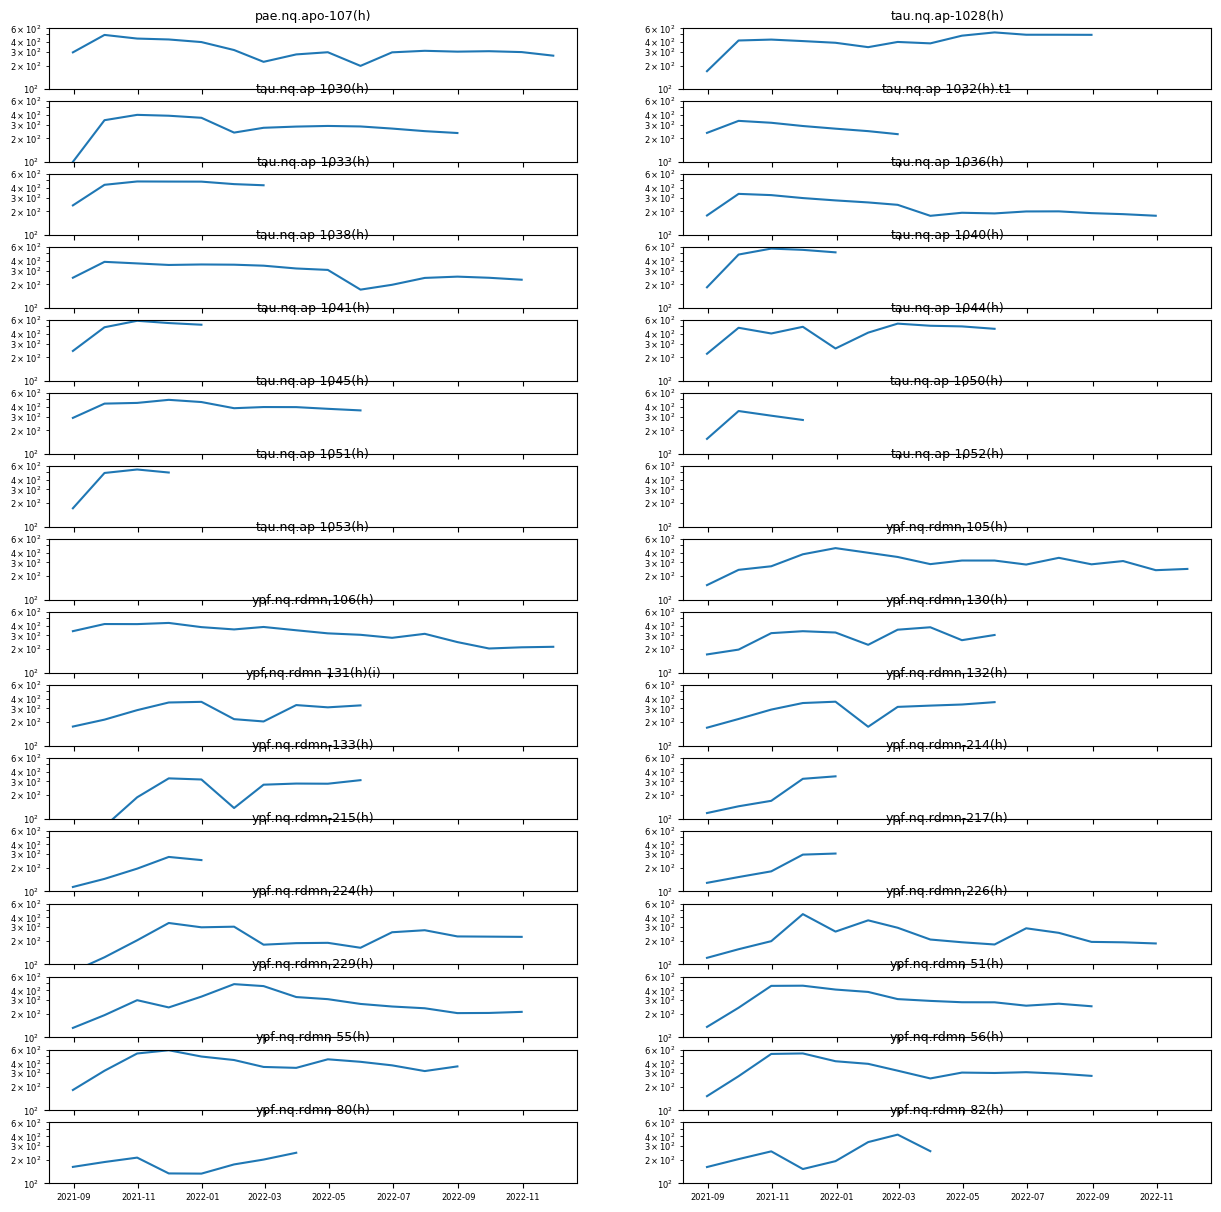

In [54]:
row= math.ceil(int(df_new_wells_2.shape[1]/2))
fig, axs = plt.subplots(row,2 , figsize = (15,15), sharex = True)
axx = axs.ravel()
for col, ax in zip(df_new_wells_2.columns[0:], axs.flatten()):
    ax.plot(df_new_wells_2.index, df_new_wells_2[col])
    #ax.set(xlabel = 'time', ylabel = ' prod')
    ax.set_title(df_new_wells_2[col].name, size=9)
    ax.tick_params(axis='y', which='both', labelsize = 6)
    ax.tick_params(axis='x', which='both', labelsize = 6)
    ax.set_yscale('log')
    ax.set_ylim([100,600])
plt.show()

In [86]:
timeseries_new_wells = []
for i in df_new_wells_2:
    a = df_new_wells_2.loc[:,i].first_valid_index()
    b= df_new_wells_2.index[-1]
    timeseries_new_wells.append(np.trim_zeros(df_new_wells_2.loc[a:b,i], trim='f')) 
#print(timeseries_new_wells)    

In [87]:
# borro los None desde el ultimo dato valido
timeseries_new_wells_2 = []
time_max = df_new_wells_2.index.max()
for ts in timeseries_new_wells:
    time_last_prod_new_wells = ts.last_valid_index()
    ts_new_wells_2 = ts.loc[:time_last_prod_new_wells]
    timeseries_new_wells_2.append(ts_new_wells_2)
#print(timeseries_new_wells_2)

In [88]:
# los valores nulos que se encuentran en el medio del dataset los cambio por 0 (pozo cerrado) ya que no lo soporta json
for ts in timeseries_new_wells_2:
    ts.fillna(value=0, inplace=True)

In [89]:
time_series_new_wells_testing = []
timeseries_new_wells_3 = []
for ts in timeseries_new_wells_2:
    if len(ts)>(prediction_length+1):
        time_series_new_wells_testing.append(ts[:-prediction_length])
        timeseries_new_wells_3.append(ts[:])
    else:
        continue
#print(time_series_new_wells_testing)

In [90]:
predictor.set_prediction_parameters(freq,prediction_length)
list_of_df_new_wells = predictor.predict(ts=time_series_new_wells_testing[:])
actual_data_new_wells=timeseries_new_wells_3[:]
#print(list_of_df_new_wells)

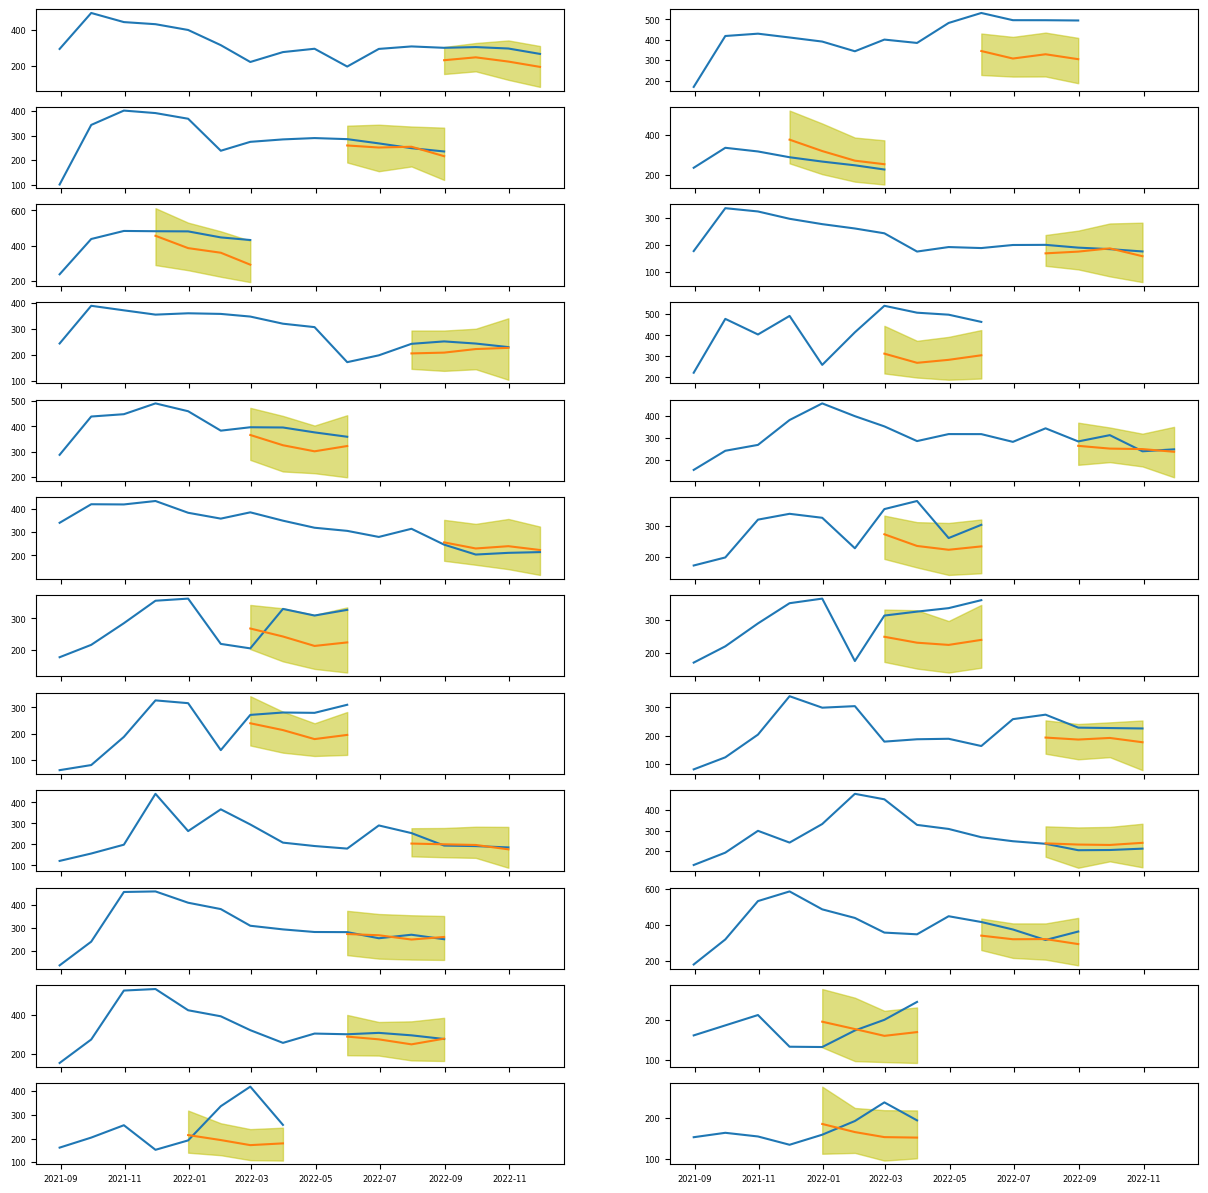

In [91]:
plot_predictions(list_of_df_new_wells, actual_data_new_wells)

In [92]:
list_of_df_new_wells = predictor.predict(ts=timeseries_new_wells_2[3:15])
actual_data_new_wells=timeseries_new_wells_2[3:15]

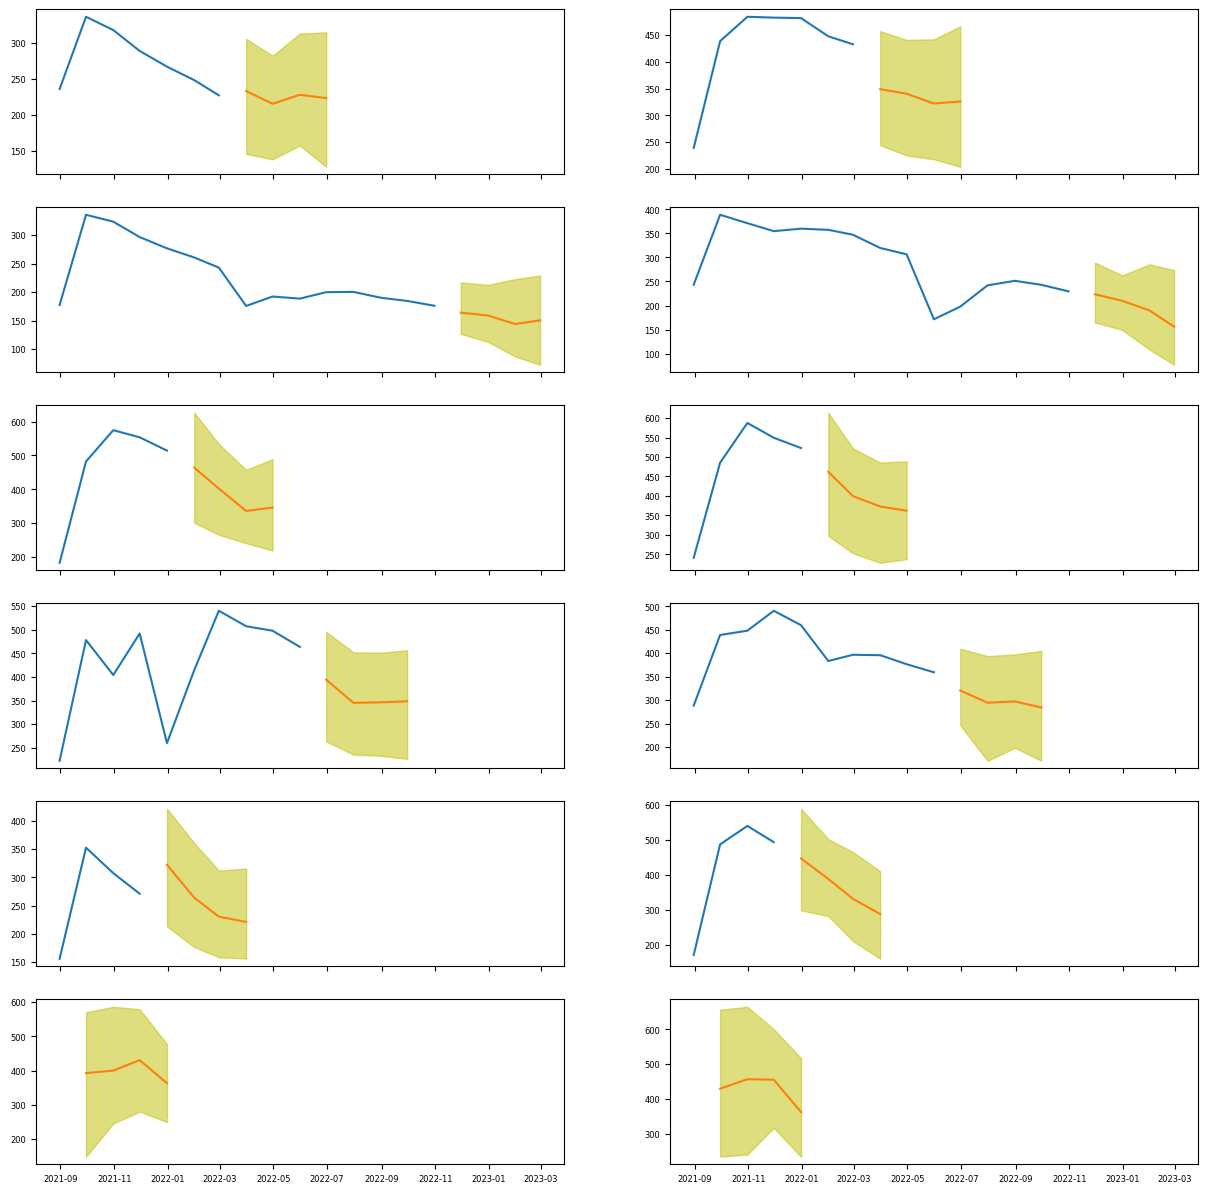

In [93]:
plot_predictions(list_of_df_new_wells, actual_data_new_wells)